# Imports

In [17]:
from copy import deepcopy

import graphviz
import numpy as np
import pydot
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import callbacks, layers
from tensorflow.keras import utils as kutils
from tensorflow.keras.layers import Concatenate

# Methods

## Data loaders

In [18]:
def get_iris(**tts_kwargs) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    data = load_iris()
    X = data["data"]
    y = kutils.to_categorical(data["target"])
    return train_test_split(X, y, **tts_kwargs)

## Model makers

In [19]:
def make_classic_dense(layer_sizes: list[int]) -> keras.Model:
    input_size, output_size = layer_sizes[0], layer_sizes[-1]
    model = keras.Sequential()
    model.add(layers.Dense(layer_sizes[1], input_dim=input_size, activation="relu"))
    for size in layer_sizes[2:-1]:
        model.add(layers.Dense(size, activation="relu"))
    model.add(layers.Dense(output_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


def define_stacked_model(models: list[keras.Model]) -> keras.Model:
    for i, layer in [
        [i, layer] for i, model in enumerate(models) for layer in model.layers
    ]:
        layer.trainable = False
        layer._name = "stack_" + str(i + 1) + "_" + "_".join(layer.name.split("_")[-2:])
    stacked_input = [model.input for model in models]
    stacked_output = [model.layers[-2].output for model in models]
    merge = Concatenate()(stacked_output)
    hidden = layers.Dense(10, activation="relu")(merge)
    output = layers.Dense(3, activation="softmax")(hidden)
    model = keras.Model(inputs=stacked_input, outputs=output)
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


def stacked_fit(
    model: keras.Model, xtr: np.ndarray, ytr: np.ndarray, **kwargs
) -> callbacks.History:
    xtr_mul = [xtr for _ in range(len(model.input))]
    if "validation_data" in kwargs:
        kwargs["validation_data"] = (
            [kwargs["validation_data"][0] for _ in range(len(model.input))],
            kwargs["validation_data"][1],
        )
    return model.fit(xtr_mul, ytr, **kwargs)


def stacked_evaluate(
    model: keras.Model, xts: np.ndarray, yts: np.ndarray, **kwargs
) -> tuple[float, float]:
    xts_mul = [xts for _ in range(len(model.input))]
    return model.evaluate(xts_mul, yts, **kwargs)

## Utils

In [20]:
def plot_history(history: callbacks.History, sup_txt: str = ""):
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 4))

    fig.suptitle(f"History {sup_txt}")

    ax_loss.plot(history.history["loss"], label="train")
    ax_loss.plot(history.history["val_loss"], label="test")
    ax_loss.grid()
    ax_loss.set_ylabel("Loss")
    ax_loss.set_xlabel("Epochs")
    ax_loss.legend()

    ax_acc.plot(np.array(history.history["accuracy"]) * 100, label="train")
    ax_acc.plot(np.array(history.history["val_accuracy"]) * 100, label="test")
    ax_acc.grid()
    ax_acc.set_ylabel("Accuracy [%]")
    ax_acc.set_xlabel("Epochs")
    ax_acc.legend()
    return fig, (ax_loss, ax_acc)

# Experiments

## Basic Iris POC

[<Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>]

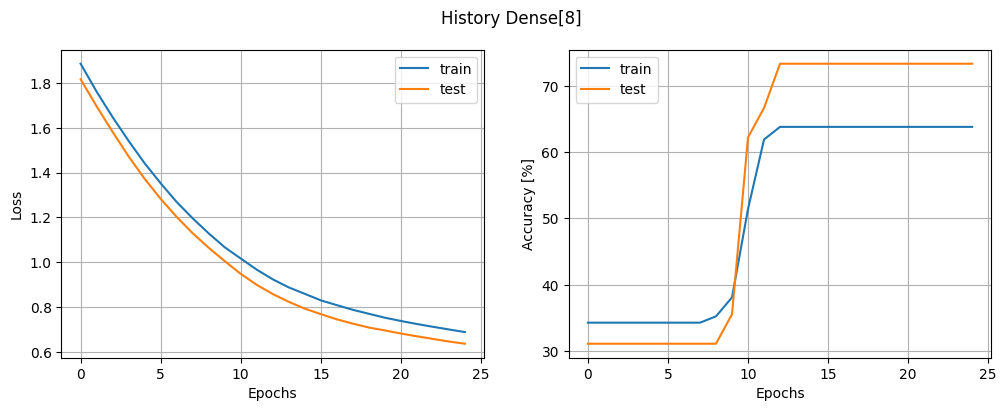

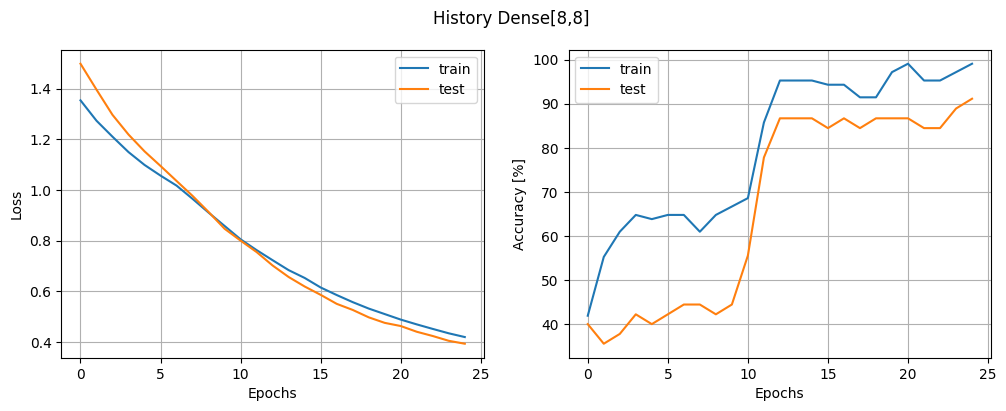

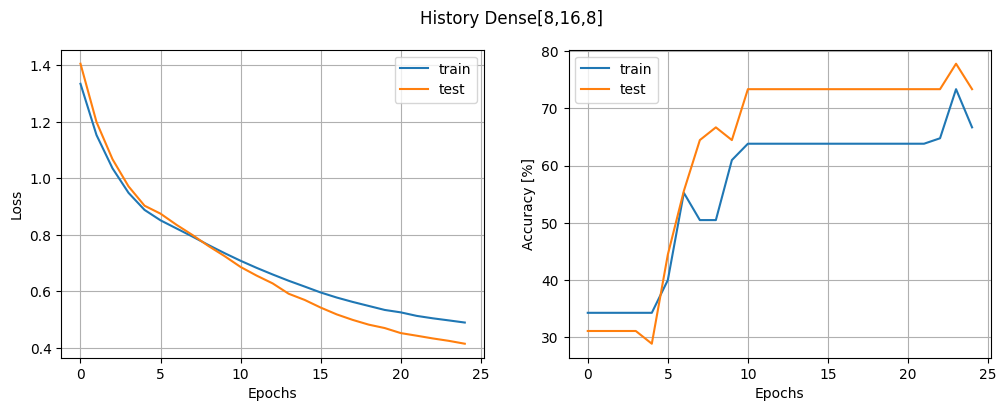

In [21]:
models = {
    "Dense[8]": make_classic_dense([4, 8, 3]),
    "Dense[8,8]": make_classic_dense([4, 8, 8, 3]),
    "Dense[8,16,8]": make_classic_dense([4, 8, 16, 8, 3]),
}
xtr, xts, ytr, yts = get_iris(train_size=0.7, shuffle=True)
histories = {
    name: model.fit(
        xtr, ytr, validation_data=(xts, yts), epochs=25, batch_size=10, verbose=0
    )
    for name, model in models.items()
}
[plot_history(history, name)[0] for name, history in histories.items()]

In [22]:
[
    [name, model.evaluate(xts, yts, batch_size=10, verbose=0)]
    for name, model in models.items()
]

[['Dense[8]', [0.6369082927703857, 0.7333333492279053]],
 ['Dense[8,8]', [0.3927711844444275, 0.9111111164093018]],
 ['Dense[8,16,8]', [0.4148417115211487, 0.7333333492279053]]]

In [25]:
stacked_model = define_stacked_model(list(models.values()))
stacked_fit(
    stacked_model,
    xtr,
    ytr,
    validation_data=(xts, yts),
    epochs=25,
    batch_size=10,
    verbose=0,
)
kutils.plot_model(stacked_model, show_shapes=True)

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [24]:
stacked_evaluate(stacked_model, xts, yts, batch_size=10, verbose=0)

[0.3598722815513611, 0.9111111164093018]